# 1.1 Setting up the system for OpenMM (NaCl)

## Imports

In [34]:
## import required packages
import time
import numpy as np
import matplotlib.pyplot as plt
import openmm.app as omm_app
import openmm as omm
import openmm.unit as unit
from tqdm.notebook import tqdm_notebook
import mdtraj

### Aims of this Notebook

This is an example notebook on how to set up a simulation system under the OpenMM suite from given CHARMM-GUI input topology and parameter files.

You will learn: 
1. Read in topology files (CHARMM psf and pdb) for a simulation
2. Read in the set of CHARMM parameters provided
3. Create and save the OpenMM system for simulation. 
4. Add a custom bias with a harmonic potential 

## Introduction

### Simulating NaCl in water

For the purpose of this workshop, we use standard parameters for Na<sup>+</sup> Cl<sup>-</sup> complex from a PDB crystal structure, solvated the system and generated the necessary files for simulation using CHARMM-GUI (topology and parameters which can be found under the `toppar/` folder). We will be using CHARMM36m as our Force Field. If you are interested on generating your own parameters for your system using CHARMM-GUI you can find videos/demos and help [here](https://www.charmm-gui.org/?doc=demo).

We will be sampling the dissociation of NaCl in water and will try to reconstruct the free energy profile from the resulting simulations. In order to sample more efficiently we will use the umbrella sampling method to bias the distance between the ionic complex.  

**Our simulated system looks like this:**

<center>
<img src="images/solvated_system.png" alt="NaCl" width="500"/>
</center>

------

## Hands-on Code

### System creation

We first import the necessary `psf/pdb` files with the topology info to be able to look up the atom parameters in the force field.

In [2]:
psf_file = 'toppar/step3_input.psf' # Path
pdb_file = 'toppar/step3_input.pdb' # Path

OpenMM has specific functions that read in whatever is necessary from the files:

In [4]:
psf = omm_app.CharmmPsfFile(psf_file)
pdb = omm_app.PDBFile(pdb_file)

From the `toppar/` folder we read in as well the parameter file with the info for our 2 ions (Na<sup>+</sup> and Cl<sup>-</sup>) as well as the parameters of the TIP3 water model.

In [5]:
params = omm_app.CharmmParameterSet('toppar/toppar_water_ions.str')

Once everything necessary is in, we can create the system to simulate in OpenMM

In [6]:
## Create an OpenMM system
system = psf.createSystem(params)

### Defining the biasing potential

Now that we have our system we can add our custom bias to it.

In this case since we want to quickly see the dissociation of NaCl, for that, we will be biasing the distance between our two complexed ions. 

The most common bias for separating them is a harmonic biasing potential. All we need to do is tell OpenMM the formula of the biasing potential and the degree of freedom we want to add the biasing potential to, the formula would look like:

$$
  U_{i} = k_{i}(r - r_{o})^2
$$

In [7]:
## add a harmonic biasing potential on butane dihedral to the OpenMM system

# Define the equation
bias_bond = omm.CustomBondForce("0.5*k*(r-r0)^2")

# Initialize parameters, these will be later set
bias_bond.addGlobalParameter("k", 1.0)  # Force constant in kJ/(mol*nm^2)
bias_bond.addGlobalParameter("r0", 0.0) # Optimal value of the distance in nm

# Define the bond
bias_bond.addBond(0, 1) # Here you would have to put the atoms you will be adding the bond to

# We add it to the system
system.addForce(bias_bond)

9

### Saving the system for the next step

Now that all is set up, we can save the file in a readble format. This will be in an XML formated text file, which can be used or re-read at any point later. You can open the file to see how the information is structured for yourself. 

In [8]:
## save the OpenMM system
with open("output_files/NaCl_solvated_system", 'w') as file_handle:
    file_handle.write(omm.XmlSerializer.serialize(system))

-------

## Optional tasks

We recommend if time and your resources allow, or at home, to try the following:


# 1.2 Running Umbrella Sampling on NaCl

## Introduction

In **umbrella sampling**, the reaction coordinate (or collective variable, CV) which we want to sample is split into multiple windows and in each window, the CV (an atomic distance in our NaCl example) is restrained around each centre using a (harmonic) biasing potential. We will run simulations in each window sequentially, but of course they can run in parallel in your typical workstation.

<center>
<img src="images/US.jpg" alt="NaCl" width="500"/>
</center>

**Note:** From this production, the data we will get will be **biased**. in order to be able to get back any kinetics or a correct free energy profile, we will need to unbias it, which is explained in section 1.4.

-------

## Hands-on Code

### Setting up the OpenMM context for simulation

To run our simulations we need to construct an OpenMM **context**, which needs a **system**, an **integrator** and a **platform**. Here we will use Langevin Dynamics for NVT ensemble simulation. The platform specifies on what kind of hardware we will run the simulations.

In [8]:
## reading in the OpenMM system we created
with open("output_files/NaCl_solvated_system", 'r') as file_handle:
    xml = file_handle.read()
system = omm.XmlSerializer.deserialize(xml)

OpenMM works with multiple computer architectures, by [default](http://docs.openmm.org/7.7.0/userguide/application/02_running_sims.html#platforms), it selects the optimal. In case you need to specify the platform, it can be done explicitly. The CPU option should work on every computer, but if you can, try out CUDA or OpenCL for GPU speeds.

In [9]:
# Setting up the platform

# platform = omm.Platform.getPlatformByName('CUDA')     # If you have GPU try this
# platform = omm.Platform.getPlatformByName('OpenCL')   # Or this one, if the preivous does not work
# platform = omm.Platform.getPlatformByName('CPU')      # Try first using CUDA or OpenCL it is way faster

Now we set up all simulation-related parameters to ready up the context for our simulations

In [16]:
#### setup an OpenMM context

T = 298.15      # temperature in K
fricCoef = 10   # friction coefficient in 1/ps
stepsize = 2    # integration step size in fs
dcdfreq = 100   # save coordinates at every 100 step
steps = 100000  # total steps

integrator = omm.LangevinIntegrator(T*unit.kelvin, #Desired Integrator
                                    fricCoef/unit.picoseconds,
                                    stepsize*unit.femtoseconds) 
## construct an OpenMM context
context = omm.Context(system, integrator)   # you may pass platform as a third positional argument

### Placing the umbrellas 

We will place the different umbrella centers in equidistantly spaced points. However, the umbrellas could also be placed geometrically, if an uneven potential requires more sampling in a certain region.

In [10]:
M = 10          # number of windows
start = 0.25    # First center (in nm)
end = 0.7       # Stop before this distance (in nm)

# Setting the centers for the umbrellas we'll use
umbrella_centers = np.linspace(start, end, M, endpoint=False)

# We will save the centers in a .csv for when we need to check it
np.savetxt("output_files/bias.csv", umbrella_centers, delimiter = ",")

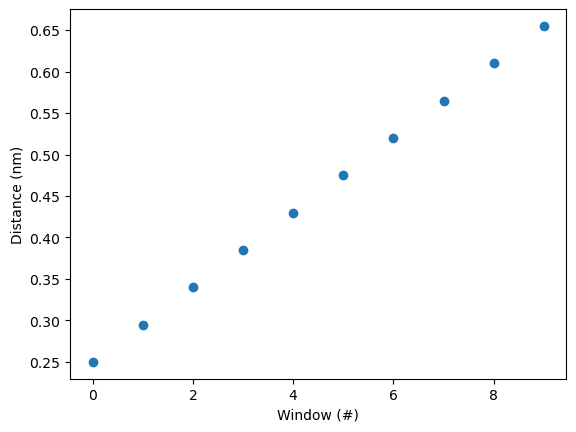

In [86]:
# Here you can plot at which distance each umbrella will be placed for each window
plt.plot(range(M), umbrella_centers, "o")
plt.ylabel("Distance (nm)")
plt.xlabel("Window (#)")
plt.savefig("images/lin_spaced_windows.png")

The points in the plot show at which distance each of the potentials is going to be placed. 

Now that the centers for the harmonic biasing potentials are defined, let's give the force constant a value for biasing the Na-Cl distance. 

In [32]:
# set force constant K for the biasing potential. 
# the unit here is kJ*mol^{-1}*nm^{-2}, which is the default unit used in OpenMM
K = 25000 * unit.kilojoules_per_mole / ((unit.nano * unit.meter)**2)  # This is app. 60 kcal/(mol*A^2)
context.setParameter("k", K)

### Running the umbrella sampling

For running the simulations we will have to create a loop iterating the umbrellas by window _M_, each configuration is minimized and equilibrated with the biasing potential and after that they are sampled and saved.

In [35]:
# The main loop to run umbrella sampling window by window
st = time.time()

#For saving the trajectories (.dcd ) in the correct topology we have to load them again

for window in range(M):
    s = time.time()
    print(f"Sampling at window: {window+1} out of {M}")
    
    # Set the center of the biasing potential for each window
    context.setParameter("r0", umbrella_centers[window]  * (unit.nano * unit.meter))

    # Minimizing step 
    context.setPositions(pdb.positions)
    state = context.getState(getEnergy = True)
    energy = state.getPotentialEnergy()
    
    for i in tqdm_notebook(range(50), desc="Minimization Win {}".format(window+1)):
        omm.LocalEnergyMinimizer_minimize(context, 1, 20)
        state = context.getState(getEnergy = True)
        energy = state.getPotentialEnergy()
        
    print("Minimization in:", str(time.time() - s), "seconds")
    s = time.time()
    
    # Initial equilibration step
    integrator.step(500)
    
    print("Equilibration in:", str(time.time() - s), "seconds")
    s = time.time()

    # Sampling production. trajectories are saved in dcd files
    file_handle = open(f"trajectories/traj_win{window+1}_US.dcd", 'bw')
    dcd_file = omm_app.dcdfile.DCDFile(file_handle, psf.topology, dt = stepsize)
    for i in tqdm_notebook(range(int(steps/dcdfreq)), desc="Production"):
        integrator.step(dcdfreq)
        state = context.getState(getPositions = True)
        positions = state.getPositions()
        dcd_file.writeModel(positions)
    file_handle.close()
    
    print("Production Run done in:", str(time.time() - s), "seconds")

Sampling at window: 1 out of 10


Minimization Win 1:   0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 

Once the simulations have finished, we will have the corresponding trajectories in the `trajectories/` folder for further analysis. Our next step is to calculate the RC obtained for each window.


-------

## Optional tasks


We recommend if time allows, or at home, to try the following:
- Try changing the number of umbrellas. How does it affect the obtained free energy profile?.
<!-- ***Answer:*** A very small number of umbrellas will make your windows very spread and sample very little, whereas having too many umbrellas is computationally expensive.-->
- Try also changing the spacing of windows (np.linspace). How is the sampling affecting the free energy profile?.
<!-- ***Answer:*** Having an even sampling is helpful to easily sample the whole space, but sometimes a part can be more valuable than the rest and you might want to place more umbrellas.-->
- Try modifying the force constant (K) to different values. How does it affect the sampling?.
<!-- ***Answer:*** High values will restrict the sampling to a very limited area, thus having no overlap between windows. A very low value will allow the windows to sample all configurations with too much overlap between the windows.-->

# 1.3 Computing the biased CVs

## Introduction

After running the umbrella sampling on the NaCl complex we will have to calculate their distance at each of the windows/trajectories generated in order to reconstruct the free energy profile of the dissociation in water. In our case the reaction coordinate (RC) of the process is the interatomic distance between Na and Cl. For this we will use the mdtraj module which quickly loads the trajectory and calculates the distances for the atoms we specify.

<center>
<img src="images/dissociation.png" alt="NaCl" width="500"/>
</center>

-------

## Hands-on Code

### Loading trajectory and calculating distances

In order for mdtraj to calculate the distances we need to specify the topology for the `.dcd` file we saved. Additionally, we will have to provide the atom index for the atoms we want to calculate the distance of. In our case 0 and 1 (python indexing based) are the relevant atoms. Then we will save the data in a `.csv` file for later analysis with the unbiasing tools to recover the profiles.

In [36]:
#We need to load the topology so mdtraj knows what is what
topology = mdtraj.load_psf('toppar/step3_input.psf')

#Depending on the number of umbrellas we used we will have the same trajectories
all_dists = []
for window in range(M):
    try:
        traj = mdtraj.load_dcd(f"trajectories/traj_{window+1}_US_test.dcd", topology)
    except OSError:
        traj = mdtraj.load_dcd(f"trajectories/long_traj/traj_win{window+1}_US.dcd", topology)
    dist = mdtraj.compute_distances(traj, [[0, 1]]) # Calculate distance
    np.savetxt(f"output_files/dist_win_{window+1}.csv", dist, fmt = "%.5f", delimiter = ",")    # Save them for later analysis
    all_dists.append(dist.T[0])     # Append to the list
    
all_dists = np.array(all_dists) * 10    # We multiply by 10 so it's in Angstroms when we plot them

After calculating the distances, we'll make a few checks to see if the sampled datapoints are correct and if they sample the space.

Text(0.5, 0, 'Time (ns)')

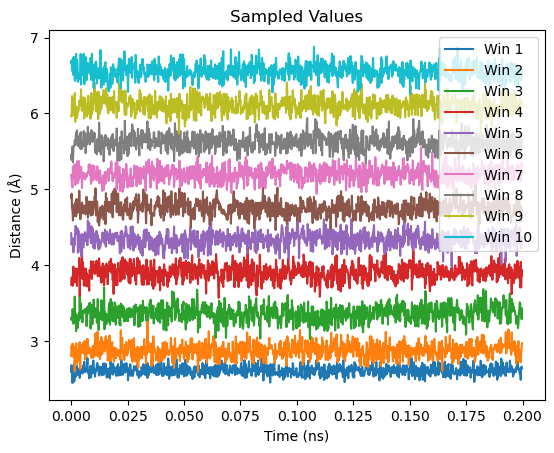

In [77]:
t = np.arange(0, steps * stepsize, dcdfreq * stepsize) * unit.femtosecond_base_unit.conversion_factor_to(unit.nano * unit.second_base_unit)
plt.title("Sampled Values")
for window in range(M):
    plt.plot(t, all_dists[window], label=f"Win {window+1}")
plt.legend()
plt.ylabel("Distance (Å)")
plt.xlabel("Time (ns)")

As seen previously the windows sample throughout the RC space, from 2 Å up to 7 Å the endpoint of our umbrella centers. We see some overlapping, but we want to see how well the windows overlap, otherwise the space in between could not be sampled properly.

Text(0.5, 0, 'Distance in Angstroms')

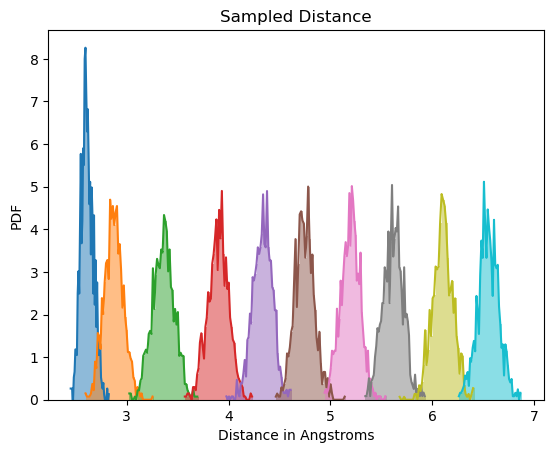

In [16]:
plt.title("Sampled Distance")
for n, dist in enumerate(all_dists):
    counts, bins, _ = plt.hist(dist, bins=50, density=True, alpha=0.5, color=f"C{n}")
    plt.plot(bins[:-1], counts, c=f"C{n}")
plt.ylabel("PDF")
plt.xlabel("Distance (Å)")

You can nicely see how each umbrella window has sampled a region of the RC and you see more centers have been placed between 2 Å and 4 Å, which is the region where the energy barrier of the dissociation can be found. We can plot the resulting sampled histogram for all trajectories to see how its profile looks like

Text(0.5, 0, 'Distance (Å)')

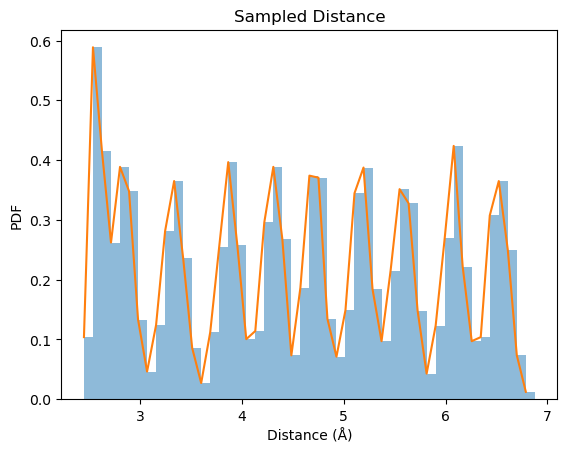

In [49]:
plt.title("Sampled Distance")
counts, bins, _ = plt.hist(np.concatenate(all_dists), bins=50, density=True, alpha=0.5)
plt.plot(bins[:-1], counts)
plt.ylabel("PDF")
plt.xlabel("Distance (Å)")

If the data were to be unbiased, we could have tried to simply construct the profile from the resulting histogram. As you see, the profile resembles the one of a dissociation, we did sample throughout the RC, but even the umbrellas can be seen from here. 

-----

## Optional tasks

We recommend if time allows, or at home, to try the following:
- Try generating the histograms with less data using `all_dists[start:end]` i.e. `all_dists[0:500]` or striding the data `all_dists[::10]`.

# 1.4 Unbiasing the data

## Weighted Histogram Analysis Method (WHAM)

The Weighted Histogram Analysis Method [(WHAM)](http://doi.org/10.1002/jcc.540130812) can be used to recover the unbiased potential. WHAM expresses the probability of finding the system in certain bins by using the probabilities obtained at the biased potential. As the width of the bins approach zero, the formalism converges to the equation of Multistate Bennett Acceptance Ratio [(MBAR)](http://doi.org/10.1063/1.2978177). The free energy then takes the following form:
$
F_i = -\frac{1}{kT} \ln\left(\sum_{j=1}^S\sum_{n=1}^{N_j} \frac{\exp\left(-\frac{V_i(x_{jn})}{kT}\right)}{\sum_{k=1}^S N_k \exp\left(\frac{F_k-V_k(x_{jn})}{kT}\right)} \right)
$
where $N_k$ is the sample size of simulation $k$; $V_i(x_j)$ is the biasing potential; $k$ is the Boltzmann constant; $T$ is the temperature.

This formalism implies a self-consistent solution, which if provided in a utility script. We can use the data extracted in the previous step, of load it again.

In [18]:
# read distance values from the umbrella sampling if not in memory
if all_dists not in locals():
    all_dists = []
    for window in range(M):
        dist = np.loadtxt(f"output_files/dist_win_{window+1}.csv", delimiter = ",")
        all_dists.append(dist*10) # We convert them to Angstroms
    all_dists = np.array(all_dists)

We need to prepare the data for the WHAM implementation. The values of the colvars (in this case a single distance) have to be in an 3D array, shaped _(number of sims, points per sims, number of colvars)_ where the last can be omitted if a single variable was biased. Similarly, the force constants and the bias positions have to be in a 2D array, shaped _(number of sims, number of colvars)_ with again the option of ignoring the number of colvars if it is 1.

We also need some unit conversion, to go from the openMM base units to the kcal--Å realm.

In [61]:
k_val = [K.value_in_unit(unit.kilocalorie_per_mole / unit.angstrom**2) for _ in range(M)]
centers = umbrella_centers * 10 # convert to Angstrom

In [68]:
from src.wham import WHAM
w = WHAM()
w.setup(all_dists, T, k_val, centers)
w.converge(0.000001)
w.project_1d([1], 50)

/home/berta/PycharmProjects/enhanced-sampling-workshop-2022/Day1/1.Umbrella_Sampling_NaCl/src/wham.py:122: RuntimeWarning: divide by zero encountered in log
  self.qspace12 = qspace12


After the iteration converged, we can reintroduce binning along a selected coordinate. Since we only have one colvar in this example, we give it a weight of 1, and proceed with a moderate 50 bins.

Text(0.5, 0, 'Distance (Å)')

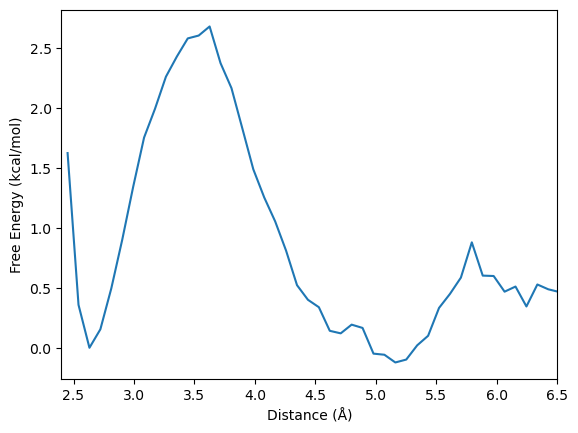

In [69]:
plt.plot(w.qspace12, w.rUep)
plt.xlim(2.4, 6.5)
plt.ylabel("Free Energy (kcal/mol)")
plt.xlabel("Distance (Å)")

## Dynamic Histogram Analysis Method (DHAM)

Instead of the probability of being in a certain state, [DHAM](http://doi.org/10.1021/ct500719p) analysis the transitions occurring during the simulation between bins. Based on the transitions histograms, a Markov matrix can be constructed. Solving the eigenvalue problem of the Markov matrix will lead to the equilibrium probabilities in the first eigenvector.

DHAM does not require an iterative solution, and it is equivalent to WHAM if the trajectories are uncorrelated. We use it similarly to the WHAM, with a utility class provided. This implementation deals with a single coordinate, hence the required format of the data will be a 2D array shaped _(number of sims, points per sims)_, while the umbrellas are defined in 1D arrays. (Ergo the same arrays we used for WHAM will suffice.)

In [70]:
from src.dham import DHAM
d = DHAM()
d.setup(all_dists, T, k_val, centers)

We can now run a loop of different lagtimes and number of bins and plot the results.

In [81]:
results = []
labels = []
for l in [1, 2, 3]:
    for n in [60]:
        d.lagtime = l
        d.numbins = n
        results.append(d.run(biased=True, plot=False))
        labels.append("Lagtime = {0:d}, nbins = {1:d}".format(l, n))

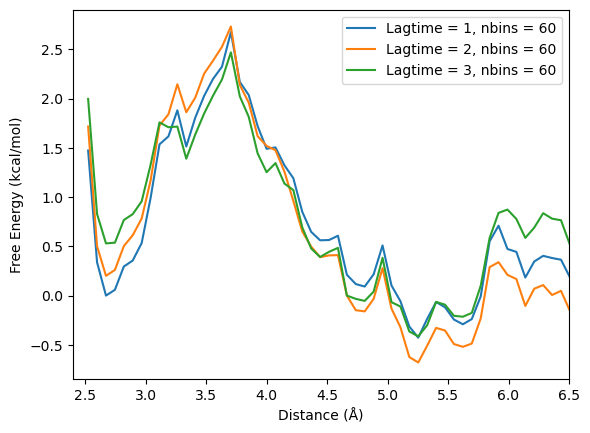

In [84]:
f, a = plt.subplots()
for i in range(len(results)):
    a.plot(results[i][0], results[i][1], label=labels[i])
plt.xlim(2.4, 6.5)
plt.ylabel("Free Energy (kcal/mol)")
plt.xlabel("Distance (Å)")
plt.legend()

In [85]:
[r[2] for r in results]

[(2.7507267375161258e+17+0j),
 (6.900464838523866e+17+0j),
 (2.549999211445027e+17+0j)]